# COVID Global Clustering Scratchpad 

Do the same using Global data from John Hopkins University

https://github.com/CSSEGISandData/COVID-19   

https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv


## Clustering thoughts
- Take case + death counts
- Trending pattern (?  what is a good single value metric.. rolling 3 day or some momentum value?)
- Adding population data
- Population density ?
- Median age and age distributions

Attempt to cluster the countries ?


In [407]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO
import pandas as pd
import requests

dfc_graw = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
dfd_graw = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')

dfc_g = dfc_graw.drop(columns=['Lat','Long','Province/State']).groupby(['Country/Region']).sum().sort_values(dfc_graw.columns[-1], ascending=False)
dfc_g = dfc_g.transpose()  
dfc_g.index = pd.to_datetime(dfc_g.index)
display('cases',dfc_g.tail())
display('chg in cases',dfc_g.tail().diff(axis=0))

dfd_g = dfd_graw.drop(columns=['Lat','Long','Province/State']).groupby(['Country/Region']).sum().sort_values(dfd_graw.columns[-1], ascending=False)
dfd_g = dfd_g.transpose().tail(40)  # last 40 days ?
dfd_g.index = pd.to_datetime(dfd_g.index) 
display('deaths',dfd_g.tail())
display('chg in deaths',dfd_g.tail().diff(axis=0))

#display('details of', dfd_g['Sudan'].tail(15), dfc_g['Sudan'].tail(15))


'cases'

Country/Region,US,Spain,Italy,France,Germany,United Kingdom,Turkey,China,Iran,Russia,...,Holy See,MS Zaandam,Papua New Guinea,Mauritania,Western Sahara,Bhutan,Burundi,Sao Tome and Principe,South Sudan,Yemen
2020-04-16,667592,184948,168941,147091,137698,104145,74193,83403,77995,27938,...,8,9,7,7,6,5,5,4,4,1
2020-04-17,699706,190839,172434,149130,141397,109769,78546,83760,79494,32008,...,8,9,7,7,6,5,5,4,4,1
2020-04-18,732197,191726,175925,149149,143342,115314,82329,83787,80868,36793,...,8,9,7,7,6,5,5,4,4,1
2020-04-19,759086,198674,178972,154097,145184,121172,86306,83805,82211,42853,...,8,9,7,7,6,5,5,4,4,1
2020-04-20,784326,200210,181228,156480,147065,125856,90980,83817,83505,47121,...,9,9,7,7,6,5,5,4,4,1


'chg in cases'

Country/Region,US,Spain,Italy,France,Germany,United Kingdom,Turkey,China,Iran,Russia,...,Holy See,MS Zaandam,Papua New Guinea,Mauritania,Western Sahara,Bhutan,Burundi,Sao Tome and Principe,South Sudan,Yemen
2020-04-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-17,32114.0,5891.0,3493.0,2039.0,3699.0,5624.0,4353.0,357.0,1499.0,4070.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-04-18,32491.0,887.0,3491.0,19.0,1945.0,5545.0,3783.0,27.0,1374.0,4785.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-04-19,26889.0,6948.0,3047.0,4948.0,1842.0,5858.0,3977.0,18.0,1343.0,6060.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-04-20,25240.0,1536.0,2256.0,2383.0,1881.0,4684.0,4674.0,12.0,1294.0,4268.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


'deaths'

Country/Region,US,Italy,Spain,France,United Kingdom,Belgium,Iran,Germany,China,Netherlands,...,Rwanda,Saint Kitts and Nevis,Cambodia,South Sudan,Central African Republic,Saint Vincent and the Grenadines,Chad,Dominica,Sao Tome and Principe,Saint Lucia
2020-04-16,32916,22170,19315,17941,13759,4857,4869,4052,3346,3327,...,0,0,0,0,0,0,0,0,0,0
2020-04-17,36773,22745,20002,18703,14607,5163,4958,4352,4636,3471,...,0,0,0,0,0,0,0,0,0,0
2020-04-18,38664,23227,20043,19345,15498,5453,5031,4459,4636,3613,...,0,0,0,0,0,0,0,0,0,0
2020-04-19,40661,23660,20453,19744,16095,5683,5118,4586,4636,3697,...,0,0,0,0,0,0,0,0,0,0
2020-04-20,42094,24114,20852,20292,16550,5828,5209,4862,4636,3764,...,0,0,0,0,0,0,0,0,0,0


'chg in deaths'

Country/Region,US,Italy,Spain,France,United Kingdom,Belgium,Iran,Germany,China,Netherlands,...,Rwanda,Saint Kitts and Nevis,Cambodia,South Sudan,Central African Republic,Saint Vincent and the Grenadines,Chad,Dominica,Sao Tome and Principe,Saint Lucia
2020-04-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-17,3857.0,575.0,687.0,762.0,848.0,306.0,89.0,300.0,1290.0,144.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-04-18,1891.0,482.0,41.0,642.0,891.0,290.0,73.0,107.0,0.0,142.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-04-19,1997.0,433.0,410.0,399.0,597.0,230.0,87.0,127.0,0.0,84.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-04-20,1433.0,454.0,399.0,548.0,455.0,145.0,91.0,276.0,0.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Global Population Comparisons

In [408]:
# GLobal Population 
# https://github.com/datasets/population/blob/master/data/population.csv

df_gpop = pd.read_csv('https://raw.githubusercontent.com/datasets/population/master/data/population.csv')
df_gpop_2016 = df_gpop[df_gpop['Year'] == 2016]
df_gpop_2016 = df_gpop_2016.rename(columns={'Country Name': 'Country/Region'})

display(df_gpop_2016.sort_values(by=['Value'], ascending=False).head(), dfc_g.tail(1).transpose().count())  #262 countries / n countries
df_gmerged = pd.merge(left=dfc_g.rename(columns={'US':'United States'}).tail(1).transpose(), right=df_gpop_2016, on='Country/Region').rename(columns={'Value':'Population'})
df_gmerged = df_gmerged.rename(columns={ df_gmerged.columns[1]: "Cases" })

display(df_gmerged.rename(columns={'US':'United States'}).sort_values(by=['Population'], ascending=False).head())

df_gmerged = pd.merge(left=dfd_g.rename(columns={'US':'United States'}).tail(1).transpose(), right=df_gmerged, on='Country/Region')
df_gmerged = df_gmerged.rename(columns={ df_gmerged.columns[1]: "Deaths" })
       
display(df_gmerged.sort_values(by=['Population'], ascending=False).head(), df_gmerged.tail(1).transpose().count())



,Country/Region,Country Code,Year,Value
2711,World,WLD,2016,7426103221
1000,IDA & IBRD total,IBT,2016,6256138021
1531,Low & middle income,LMY,2016,6227752871
1885,Middle income,MIC,2016,5557635482
941,IBRD only,IBD,2016,4687686335


2020-04-20    185
dtype: int64

,Country/Region,Cases,Country Code,Year,Population
7,China,83817,CHN,2016,1378665000
14,India,18539,IND,2016,1324509589
0,United States,784326,USA,2016,322941311
32,Indonesia,6760,IDN,2016,261554226
8,Brazil,40743,BRA,2016,206163058


,Country/Region,Deaths,Cases,Country Code,Year,Population
7,China,4636,83817,CHN,2016,1378665000
17,India,592,18539,IND,2016,1324509589
0,United States,42094,784326,USA,2016,322941311
18,Indonesia,590,6760,IDN,2016,261554226
9,Brazil,2587,40743,BRA,2016,206163058


158    6
dtype: int64

## Add Population Density from worldbank

In [409]:
# population density source
# http://api.worldbank.org/v2/en/indicator/EN.POP.DNST?downloadformat=csv   
from zipfile import ZipFile
import requests, zipfile, io
import urllib.request

def get_zip(url):
    urllib.request.urlretrieve(url, "GDP.zip")
    compressed_file = zipfile.ZipFile('GDP.zip')
    files = compressed_file.namelist()
    for f in files:
        if (f.find('API') == 0):
            csv_file = compressed_file.open(f)  # pattern match how?
            return pd.read_csv(csv_file, header=2)
    return None

def isfloat(value):
  try:
    float(value)
    return True
  except ValueError:
    return False

def add_metric(indicator, colname, dfm, year='2019', debug=True):
    dfnew = get_zip('http://api.worldbank.org/v2/en/indicator/'+indicator+'?downloadformat=csv')
    dfnew = dfnew.fillna(method='ffill', axis=1)[['Country Code', year]].rename(columns={year:colname})

    dfm = pd.merge(left=dfm , right=dfnew, on ='Country Code') 
    display(dfm[dfm['Country/Region'].isin(['Dominica','Japan'])].head()) if debug else None

    dfm[colname] = dfm[colname].astype(str).apply(lambda x: float(x) if isfloat(x) else 0.0).round(2)
    return dfm


## Add demographics from worldbank

In [410]:
#  -- all available https://data.worldbank.org/indicator
#  API docs https://datahelpdesk.worldbank.org/knowledgebase/articles/898581-api-basic-call-structures
#
#   Examples:
# unemployment data http://api.worldbank.org/v2/en/indicator/SL.UEM.TOTL.ZS?downloadformat=csv
# hospital beds http://api.worldbank.org/v2/en/indicator/SH.MED.BEDS.ZS?downloadformat=csv
# air flights http://api.worldbank.org/v2/en/indicator/IS.AIR.DPRT?downloadformat=csv
# rail lines http://api.worldbank.org/v2/en/indicator/IS.RRS.TOTL.KM?downloadformat=csv
# employment F http://api.worldbank.org/v2/en/indicator/SL.TLF.CACT.FE.ZS?downloadformat=csv
# employment M http://api.worldbank.org/v2/en/indicator/SL.TLF.CACT.MA.ZS?downloadformat=csv
# unemployment http://api.worldbank.org/v2/en/indicator/SL.UEM.TOTL.ZS?downloadformat=csv
# urban pop% http://api.worldbank.org/v2/en/indicator/SP.URB.TOTL.IN.ZS?downloadformat=csv
# pollution EN.ATM.PM25.MC.M3
# slum% indicator/ EN.POP.SLUM.UR.ZS

df_gmerged3 = df_gmerged.copy()  # df_gmerged2 no longer needed

df_gmerged3 = add_metric('IS.AIR.DPRT', 'flights', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('EN.ATM.PM25.MC.M3', 'pollution', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('SL.UEM.TOTL.ZS', 'unemp%', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('SH.MED.BEDS.ZS', 'hospbeds', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('IS.RRS.TOTL.KM', 'railways', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('SP.URB.TOTL.IN.ZS', 'urbanpop%', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('EN.POP.SLUM.UR.ZS', 'slum%', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('EN.POP.DNST', 'popdensity%', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('NY.GDP.PCAP.PP.CD', 'GDP/cap', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('SE.ADT.LITR.ZS', 'literacy', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('FR.INR.DPST', 'deposit rate', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('SH.DTH.COMM.ZS', 'COD disease', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('SH.IMM.IDPT', 'DTP immunized', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('SP.POP.65UP.TO.ZS', 'pop% >= 65', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('TG.VAL.TOTL.GD.ZS', 'trade%', df_gmerged3, year='2019', debug=False)


df_gmerged3 = df_gmerged3.sort_values(by='Cases', ascending=False).drop(columns=['Year'])

df_x = pd.concat([df_gmerged3.head(0), df_gmerged3[df_gmerged3['Country/Region'].isin(['Japan','Brazil','India'])]], axis=0)

display(df_gmerged3.shape, df_x[['Country/Region','Cases','flights','railways','hospbeds','popdensity%','pop% >= 65','pollution','GDP/cap','COD disease','urbanpop%','unemp%']].transpose())


(159, 20)

,9,17,27
Country/Region,Brazil,India,Japan
Cases,40743,18539,10797
flights,832683,1.20011e+06,999594
railways,32622,68443,16851.7
hospbeds,2.2,0.7,13.4
popdensity%,25.06,454.94,347.07
pop% >= 65,8.92,6.18,27.58
pollution,12.71,90.87,11.7
GDP/cap,16096.4,7762.88,42797.5
COD disease,13.9,26,12.7


In [411]:
display(df_gmerged3.shape, df_x[['Country/Region','Cases','flights','railways','hospbeds','popdensity%','pop% >= 65','pollution','GDP/cap','COD disease','urbanpop%','unemp%']].transpose())


(159, 20)

,9,17,27
Country/Region,Brazil,India,Japan
Cases,40743,18539,10797
flights,832683,1.20011e+06,999594
railways,32622,68443,16851.7
hospbeds,2.2,0.7,13.4
popdensity%,25.06,454.94,347.07
pop% >= 65,8.92,6.18,27.58
pollution,12.71,90.87,11.7
GDP/cap,16096.4,7762.88,42797.5
COD disease,13.9,26,12.7


In [412]:
# df_gmerged4 ready to go
df_gmerged4 = df_gmerged3.copy()
df_gmerged4[df_gmerged4['Country/Region'].isin(['Belarus','Poland','Spain','France','Sweden','India','Korea, South','Japan','United States','South Africa'])].transpose()


,0,2,3,17,12,27,25,52,50
Country/Region,United States,Spain,France,India,Sweden,Japan,Poland,Belarus,South Africa
Deaths,42094,20852,20292,592,1580,236,380,51,58
Cases,784326,200210,156480,18539,14777,10797,9593,6264,3300
Country Code,USA,ESP,FRA,IND,SWE,JPN,POL,BLR,ZAF
Population,322941311,46484062,66721256,1324509589,9923085,126994511,37970087,9501534,56203654
flights,9.87963e+06,641020,597412,1.20011e+06,190315,999594,123903,31676,180317
pollution,7.41,9.7,11.81,90.87,6.18,11.7,20.88,18.77,25.1
unemp%,3.68,13.96,8.43,5.36,6.48,2.29,3.47,4.59,28.18
hospbeds,2.9,3,6.5,0.7,2.6,13.4,6.5,11,2.8
railways,150462,15618,28241,68443,9708,16851.7,18536,5459,20953


# Correlation Matrix

,Deaths,Cases,Population,flights,pollution,unemp%,hospbeds,railways,urbanpop%,slum%,popdensity%,GDP/cap,literacy,deposit rate,COD disease,DTP immunized,pop% >= 65,trade%
Deaths,1.000000,0.921638,0.179720,0.718720,-0.157080,0.018647,0.087149,0.699360,0.180221,-0.179033,-0.025884,0.249139,-0.202020,-0.117622,-0.160792,0.090646,0.308337,-0.077492
Cases,0.921638,1.000000,0.223738,0.879024,-0.127767,-0.012208,0.079027,0.824378,0.165953,-0.161618,-0.023874,0.247200,-0.203422,-0.086318,-0.150565,0.083324,0.249464,-0.089643
Population,0.179720,0.223738,1.000000,0.503798,0.267416,-0.049807,-0.036975,0.612453,-0.060774,0.009955,-0.017312,-0.042647,0.024591,-0.026367,-0.018070,0.029798,0.010736,-0.141224
flights,0.718720,0.879024,0.503798,1.000000,-0.055782,-0.070206,0.057644,0.910928,0.141160,-0.138750,-0.024821,0.222829,-0.182516,-0.089135,-0.146960,0.089789,0.181807,-0.101634
pollution,-0.157080,-0.127767,0.267416,-0.055782,1.000000,0.034698,-0.385119,-0.033383,-0.230348,0.477390,-0.100991,-0.172031,0.132855,0.111566,0.416183,-0.111487,-0.466812,-0.100274
unemp%,0.018647,-0.012208,-0.049807,-0.070206,0.034698,1.000000,-0.002011,-0.011623,0.120080,0.026280,-0.125099,-0.148474,0.237484,0.130979,0.009034,-0.098822,0.062347,-0.019466
hospbeds,0.087149,0.079027,-0.036975,0.057644,-0.385119,-0.002011,1.000000,0.138858,0.388271,-0.565877,0.332303,0.305930,-0.010130,-0.163978,-0.513351,0.295807,0.601188,0.223852
railways,0.699360,0.824378,0.612453,0.910928,-0.033383,-0.011623,0.138858,1.000000,0.142949,-0.172386,-0.042580,0.182165,-0.167972,-0.069401,-0.162519,0.078569,0.251617,-0.128805
urbanpop%,0.180221,0.165953,-0.060774,0.141160,-0.230348,0.120080,0.388271,0.142949,1.000000,-0.478795,0.181979,0.606855,-0.022595,-0.110195,-0.532877,0.334991,0.408456,0.181994
slum%,-0.179033,-0.161618,0.009955,-0.138750,0.477390,0.026280,-0.565877,-0.172386,-0.478795,1.000000,-0.113728,-0.551982,-0.078594,0.289491,0.799900,-0.276597,-0.605509,-0.244386


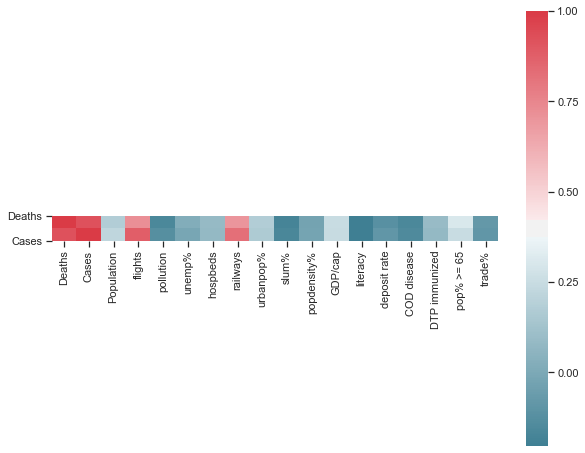

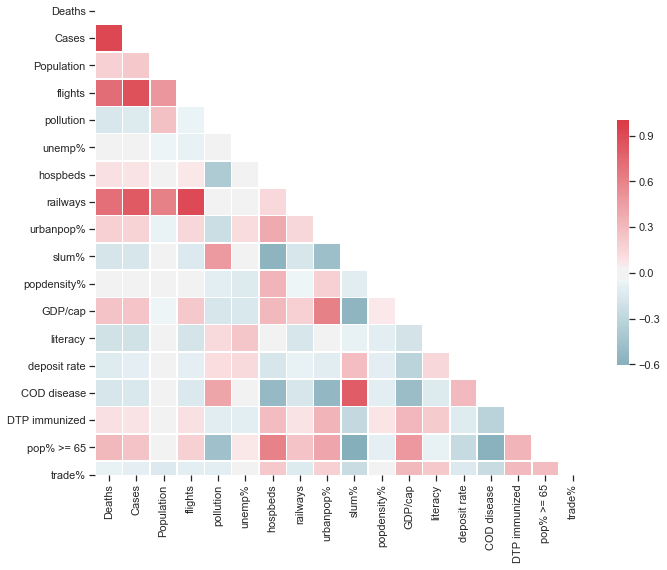

In [413]:
import seaborn as sns

df_corr = df_gmerged4.corr()

f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df_corr.iloc[0:2,:], mask=np.zeros_like(df_corr.iloc[0:2,:], dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

mask = np.triu(np.ones_like(df_corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df_corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

df_corr


## Scaling / Normalization

In [414]:
from sklearn.preprocessing import StandardScaler #used for 'Feature Scaling'
scaler = StandardScaler()

df_sc = df_gmerged4.copy().set_index('Country/Region').drop(columns=['Country Code'])
display('orig',df_sc.head(2))

df_sc = pd.DataFrame(scaler.fit_transform(df_sc), index=df_sc.index, columns=df_sc.columns)
display('scale',df_sc.head(2))

# df_sc = pd.DataFrame(scaler.inverse_transform(df_sc), index=df_sc.index, columns=df_sc.columns)
# display('inverse',df_sc.head(2))

'orig'

,Deaths,Cases,Population,flights,pollution,unemp%,hospbeds,railways,urbanpop%,slum%,popdensity%,GDP/cap,literacy,deposit rate,COD disease,DTP immunized,pop% >= 65,trade%
Country/Region,,,,,,,,,,,,,,,,,,
United States,42094,784326,322941311,9879630.0,7.41,3.68,2.9,150462.3,82.26,0.0,35.77,62794.59,0.00,0.0,5.2,94.0,15.81,20.83
Spain,20852,200210,46484062,641020.0,9.70,13.96,3.0,15618.0,80.32,0.0,93.53,39715.44,98.44,0.0,5.1,93.0,19.38,51.67


'scale'

,Deaths,Cases,Population,flights,pollution,unemp%,hospbeds,railways,urbanpop%,slum%,popdensity%,GDP/cap,literacy,deposit rate,COD disease,DTP immunized,pop% >= 65,trade%
Country/Region,,,,,,,,,,,,,,,,,,
United States,8.852050,11.271103,1.809402,10.876939,-1.012400,-0.533644,0.018517,9.518885,0.955201,-0.882278,-0.183451,1.814318,-1.967469,-0.814337,-0.772788,0.406128,1.074007,-1.121848
Spain,4.273098,2.718223,0.026889,0.472386,-0.894881,1.370712,0.060101,0.686980,0.871687,-0.882278,-0.148344,0.800173,0.798922,-0.814337,-0.777583,0.350364,1.614246,-0.266125


# Misc Clustering Techniques

## - KMeans

In [415]:
from sklearn.model_selection import train_test_split

df_gm5 = df_sc.copy()
df_train,df_test = train_test_split(df_gm5,test_size=0.2)

display('train',df_train.shape, df_train.head(3))
display('test',df_test.shape, df_test.head(3))

kmeans = KMeans(n_clusters=3, random_state=0).fit(df_train) # train on sample rows

display(f'kmeans info - inertia: {kmeans.inertia_}, iters: {kmeans.n_iter_}')    # training info 
display(f'labels: {kmeans.labels_}')                       # k-labels
#display('k centers', kmeans.cluster_centers_)                           # k-centers
#display(f'kmeans.predict x2: {kmeans.predict(df_test)}')  # evaluate 2 arb points
display(f'score {kmeans.score(df_test)}') # score
#display(f'transform: {kmeans.transform(df_test)}')  # what does this do, distance of each pt ?

def fl_col(df):
    return pd.concat([df.iloc[:,0:3],df.iloc[:,-2:]], axis=1)
    
df_train.insert(0, 'cluster', kmeans.labels_)
df_test.insert(0, 'cluster', kmeans.predict(df_test))
display('train',(df_train).head())
display('test',(df_test).head())
display(df_train[df_train.index.isin(['China','Japan','United States','Italy','Spain','India','Poland'])])

display(df_train[['cluster','Cases']].groupby(by=['cluster']).count())
display(df_test[['cluster','Cases']].groupby(by=['cluster']).count())


'train'

(127, 18)

,Deaths,Cases,Population,flights,pollution,unemp%,hospbeds,railways,urbanpop%,slum%,popdensity%,GDP/cap,literacy,deposit rate,COD disease,DTP immunized,pop% >= 65,trade%
Country/Region,,,,,,,,,,,,,,,,,,
United States,8.852050,11.271103,1.809402,10.876939,-1.012400,-0.533644,0.018517,9.518885,0.955201,-0.882278,-0.183451,1.814318,-1.967469,-0.814337,-0.772788,0.406128,1.074007,-1.121848
Moldova,-0.206696,-0.176030,-0.254759,-0.234228,-0.558745,-0.202049,1.224456,-0.260566,-0.750803,-0.882278,-0.130116,-0.625475,0.824776,0.204419,-0.820742,0.350364,0.417245,0.354024
Ghana,-0.219845,-0.198081,-0.089184,-0.233346,0.388594,-0.413233,-0.813166,-0.273534,-0.172664,0.456097,-0.125679,-0.736427,0.253737,2.173863,1.255678,0.573418,-0.853906,-0.530556


'test'

(32, 18)

,Deaths,Cases,Population,flights,pollution,unemp%,hospbeds,railways,urbanpop%,slum%,popdensity%,GDP/cap,literacy,deposit rate,COD disease,DTP immunized,pop% >= 65,trade%
Country/Region,,,,,,,,,,,,,,,,,,
Kosovo,-0.219199,-0.205871,-0.261116,-0.249533,-1.392670,-1.215359,-1.187423,-0.335953,-2.585952,-0.882278,-0.102990,-0.446335,-1.967469,-0.517105,-1.022150,-4.835654,-1.318482,-1.699822
El Salvador,-0.220276,-0.210146,-0.231844,-0.218449,-0.136907,-0.453987,-0.646829,-0.300126,0.514387,0.138277,-0.016846,-0.578889,0.533917,-0.814337,-0.504244,-0.318800,-0.063976,0.188651
Tanzania,-0.219630,-0.209619,0.069229,-0.191447,0.099671,-0.848567,-0.896334,-0.159045,-1.131780,0.908108,-0.166548,-0.802622,0.221420,1.046198,1.653698,0.629182,-0.925030,-1.094378


'kmeans info - inertia: 1586.5477490829217, iters: 6'

'labels: [2 0 1 1 1 0 1 0 1 0 1 1 0 0 1 0 0 1 0 1 0 1 0 0 1 0 0 0 0 1 0 1 0 1 1 0 0\n 0 0 1 0 0 1 1 0 1 0 0 0 0 0 0 1 0 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1 0\n 1 1 0 0 1 0 0 1 0 1 0 0 1 1 1 1 0 0 1 0 1 0 0 0 1 0 0 1 0 0 0 1 0 1 1 0 0\n 0 0 1 0 0 1 1 0 0 1 0 0 0 0 0 1]'

'score -328.6051755505272'

'train'

,cluster,Deaths,Cases,Population,flights,pollution,unemp%,hospbeds,railways,urbanpop%,slum%,popdensity%,GDP/cap,literacy,deposit rate,COD disease,DTP immunized,pop% >= 65,trade%
Country/Region,,,,,,,,,,,,,,,,,,,
United States,2,8.852050,11.271103,1.809402,10.876939,-1.012400,-0.533644,0.018517,9.518885,0.955201,-0.882278,-0.183451,1.814318,-1.967469,-0.814337,-0.772788,0.406128,1.074007,-1.121848
Moldova,0,-0.206696,-0.176030,-0.254759,-0.234228,-0.558745,-0.202049,1.224456,-0.260566,-0.750803,-0.882278,-0.130116,-0.625475,0.824776,0.204419,-0.820742,0.350364,0.417245,0.354024
Ghana,1,-0.219845,-0.198081,-0.089184,-0.233346,0.388594,-0.413233,-0.813166,-0.273534,-0.172664,0.456097,-0.125679,-0.736427,0.253737,2.173863,1.255678,0.573418,-0.853906,-0.530556
Bhutan,1,-0.221785,-0.213265,-0.268076,-0.243692,0.553839,-0.781877,-0.480493,-0.335953,-0.825277,1.589655,-0.193169,-0.498206,-0.096979,-0.360548,-0.019906,0.573418,-0.410516,0.160072
Uganda,1,-0.221785,-0.212519,-0.017191,-0.244092,1.198399,-0.874502,-0.979502,-0.318989,-1.562694,1.010517,-0.075693,-0.855448,0.183201,1.313933,1.591358,0.350364,-1.024906,-0.723676


'test'

,cluster,Deaths,Cases,Population,flights,pollution,unemp%,hospbeds,railways,urbanpop%,slum%,popdensity%,GDP/cap,literacy,deposit rate,COD disease,DTP immunized,pop% >= 65,trade%
Country/Region,,,,,,,,,,,,,,,,,,,
Kosovo,1,-0.219199,-0.205871,-0.261116,-0.249533,-1.392670,-1.215359,-1.187423,-0.335953,-2.585952,-0.882278,-0.102990,-0.446335,-1.967469,-0.517105,-1.022150,-4.835654,-1.318482,-1.699822
El Salvador,0,-0.220276,-0.210146,-0.231844,-0.218449,-0.136907,-0.453987,-0.646829,-0.300126,0.514387,0.138277,-0.016846,-0.578889,0.533917,-0.814337,-0.504244,-0.318800,-0.063976,0.188651
Tanzania,1,-0.219630,-0.209619,0.069229,-0.191447,0.099671,-0.848567,-0.896334,-0.159045,-1.131780,0.908108,-0.166548,-0.802622,0.221420,1.046198,1.653698,0.629182,-0.925030,-1.094378
South Sudan,1,-0.221785,-0.213280,-0.202982,-0.249533,0.946425,1.052084,-1.187423,-0.335953,-1.741775,2.493676,-0.205192,-0.860609,-0.997378,-0.773496,2.018151,-2.103236,-0.803968,-1.699822
Chile,0,-0.191822,-0.059490,-0.155420,-0.097878,-0.312930,0.098054,-0.272572,-0.197099,1.183357,-0.564458,-0.189881,0.163324,0.741593,-0.201722,-0.633720,0.461891,0.426325,-0.307191


,cluster,Deaths,Cases,Population,flights,pollution,unemp%,hospbeds,railways,urbanpop%,slum%,popdensity%,GDP/cap,literacy,deposit rate,COD disease,DTP immunized,pop% >= 65,trade%
Country/Region,,,,,,,,,,,,,,,,,,,
United States,2,8.852050,11.271103,1.809402,10.876939,-1.012400,-0.533644,0.018517,9.518885,0.955201,-0.882278,-0.183451,1.814318,-1.967469,-0.814337,-0.772788,0.406128,1.074007,-1.121848
Japan,0,-0.170913,-0.055244,0.545996,0.876213,-0.792244,-0.791140,4.384850,0.767784,1.358133,-0.882278,0.005758,0.935603,-1.967469,-0.741731,-0.413131,0.684946,2.855132,-0.869904
Poland,0,-0.139872,-0.072874,-0.028007,-0.109993,-0.321141,-0.572546,1.515545,0.878101,-0.000471,-0.882278,-0.129800,0.431989,0.807353,-0.814337,-0.782378,0.461891,1.332777,0.797424
Spain,0,4.273098,2.718223,0.026889,0.472386,-0.894881,1.370712,0.060101,0.686980,0.871687,-0.882278,-0.148344,0.800173,0.798922,-0.814337,-0.777583,0.350364,1.614246,-0.266125
China,0,0.777557,1.013946,8.616390,5.034622,1.309760,-0.415085,0.559110,4.086081,-0.039645,0.007618,-0.115024,-0.143651,0.753958,-0.473995,-0.839924,0.684946,0.334015,-0.757250
India,1,-0.094173,0.058118,8.267212,1.102036,3.270638,-0.222427,-0.896334,4.146863,-1.121018,-0.034758,0.071322,-0.603889,0.122500,-0.814337,0.224661,0.127309,-0.383277,-0.846318


,Cases
cluster,
0,77
1,49
2,1


,Cases
cluster,
0,19
1,13


## DBSCAN

I saw a presentation by Healy & McInnes on Youtube that basically said KMeans sucks, and we should use DBScan or their upgraded version HDBScan.   https://www.youtube.com/watch?v=ayZQj4llUSU&t=1824s


In [416]:
from sklearn.cluster import DBSCAN
import numpy as np

df_train = df_gm5
clustering = DBSCAN(eps=3, min_samples=2).fit(df_train)
components = clustering.components_
labels =clustering.labels_
core_sample_indices = clustering.core_sample_indices_
display(f'model: {clustering}')
display(labels[0:10])

display(f'core_sample_indices_[0:10]: {core_sample_indices[0:10]}')
display(f'components_[0]: {components[0]}')    
display(f'labels/fit_predict[0:10]: {labels[0:10]}')                       

def fl_col(df):
    return pd.concat([df.iloc[:,0:3],df.iloc[:,-2:]], axis=1)
    
df_train['cluster'] = clustering.labels_
display('train2',pd.concat([fl_col(df_train).head(), 
                            fl_col(df_train[df_train.index.isin(['China','Japan','United States','Italy','Spain','India','Poland'])])]))


"model: DBSCAN(algorithm='auto', eps=3, leaf_size=30, metric='euclidean',\n       metric_params=None, min_samples=2, n_jobs=None, p=None)"

array([-1,  0,  0,  1, -1,  1,  2, -1,  3,  3], dtype=int64)

'core_sample_indices_[0:10]: [ 1  2  3  5  6  8  9 10 11 12]'

'components_[0]: [ 4.27309805  2.71822324  0.02688869  0.47238554 -0.89488095  1.37071175\n  0.06010084  0.68698041  0.87168744 -0.88227803 -0.1483439   0.80017278\n  0.79892219 -0.81433719 -0.77758298  0.35036395  1.61424593 -0.26612507]'

'labels/fit_predict[0:10]: [-1  0  0  1 -1  1  2 -1  3  3]'

'train2'

,Deaths,Cases,Population,trade%,cluster
Country/Region,,,,,
United States,8.852050,11.271103,1.809402,-1.121848,-1
Spain,4.273098,2.718223,0.026889,-0.266125,0
Italy,4.976259,2.440281,0.118081,-0.305249,0
France,4.152384,2.077910,0.157372,-0.446759,1
Germany,0.826273,1.940051,0.258133,0.301027,-1
United States,8.852050,11.271103,1.809402,-1.121848,-1
Spain,4.273098,2.718223,0.026889,-0.266125,0
Italy,4.976259,2.440281,0.118081,-0.305249,0
China,0.777557,1.013946,8.616390,-0.757250,-1


## Dimension Reduction

Most research tells us due to "Curse of Dimensionality" that you need to reduce dims before you run clustering.  Hence we redo.

[Text(0, 0.5, 'PCA3')]

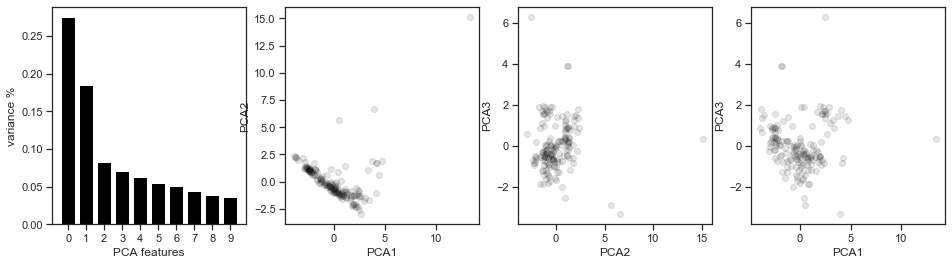

In [417]:
# method copied from kaggle: https://www.kaggle.com/minc33/visualizing-high-dimensional-clusters
#sklearn imports
from sklearn.decomposition import PCA #Principal Component Analysis
from sklearn.manifold import TSNE #T-Distributed Stochastic Neighbor Embedding
from sklearn.cluster import KMeans #K-Means Clustering
from sklearn.preprocessing import StandardScaler #used for 'Feature Scaling'

plotX = df_train.copy()

# ### delete start
# pca_1d = PCA(n_components=1)
# pca_2d = PCA(n_components=2)
# pca_3d = PCA(n_components=3)

# PCs_1d = pd.DataFrame(pca_1d.fit_transform(plotX.drop(["cluster"], axis=1)), index=plotX.index)
# PCs_2d = pd.DataFrame(pca_2d.fit_transform(plotX.drop(["cluster"], axis=1)), index=plotX.index)
# PCs_3d = pd.DataFrame(pca_3d.fit_transform(plotX.drop(["cluster"], axis=1)), index=plotX.index)

# PCs_1d.columns = ["PC1_1d"]
# PCs_2d.columns = ["PC1_2d", "PC2_2d"]
# PCs_3d.columns = ["PC1_3d", "PC2_3d", "PC3_3d"]

# plotX = pd.concat([plotX,PCs_1d,PCs_2d,PCs_3d], axis=1, join='inner')
# plotX["dummy"] = 0
# cluster0 = plotX[plotX["cluster"] == 0]
# cluster1 = plotX[plotX["cluster"] == 1]
# cluster2 = plotX[plotX["cluster"] == 2]
# cluster2.head()
# ## delete end


pca = PCA(n_components=10)
principalComponents = pca.fit_transform(plotX.drop(["cluster"], axis=1))
PCA_components = pd.DataFrame(principalComponents, index=plotX.index)

# Plot the explained variances
features = range(pca.n_components_)

fig,ax = plt.subplots(1,4, figsize=(16,4))

ax[0].bar(features, pca.explained_variance_ratio_, color='black')
ax[0].set(xlabel = 'PCA features')
ax[0].set(ylabel = 'variance %')
ax[0].set(xticks = features)

ax[1].scatter(PCA_components[0], PCA_components[1], alpha=.1, color='black')
ax[1].set(xlabel = 'PCA1')
ax[1].set(ylabel = 'PCA2')

ax[2].scatter(PCA_components[1], PCA_components[2], alpha=.1, color='black')
ax[2].set(xlabel = 'PCA2')
ax[2].set(ylabel = 'PCA3')

ax[3].scatter(PCA_components[0], PCA_components[2], alpha=.1, color='black')
ax[3].set(xlabel = 'PCA1')
ax[3].set(ylabel = 'PCA3')



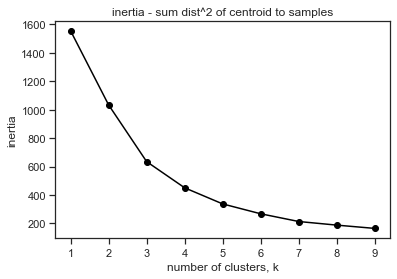

In [418]:
# KMeans on PCA columns
ks = range(1, 10)
inertias = []
for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(PCA_components.iloc[:,:3])
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.title('inertia - sum dist^2 of centroid to samples')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

## KMeans Cluster Variants and Plots

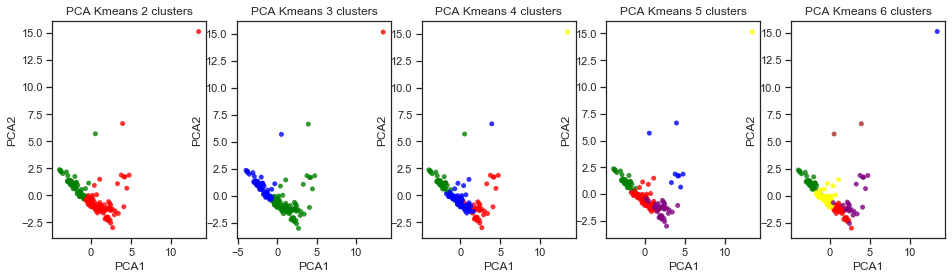

In [419]:
cluster_cases = [2,3,4,5,6]

fig,ax = plt.subplots(1,len(cluster_cases), figsize=(16,4))

for c,clusters in enumerate(cluster_cases):
    model = KMeans(n_clusters=clusters)
    PCA_components2 = PCA_components.copy()
    kmeans = model.fit(PCA_components2.iloc[:,:3])

    PCA_components2.insert(0, 'cluster', kmeans.labels_)
#     display(PCA_components2[PCA_components2.index.isin(['China','Japan','United States','Italy','Spain','India','Poland'])])
#     display(PCA_components2[['cluster',0]].groupby(by=['cluster']).count())

    datas = []
    for i in range(clusters):
        tup = []
        for j in range(clusters):
            tup.append(PCA_components2[PCA_components2['cluster']==i][j])
        datas.append(tup)

    groups = ['PCA'+str(i) for i in range(clusters)]
    colors = ('green','red','blue','yellow','purple','brown')

    for data,color,group in zip(datas,colors,groups):
        x,y = data[0],data[1]
        ax[c].scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=25, label=group)
        ax[c].set_title(f'PCA Kmeans {clusters} clusters')
        ax[c].set(xlabel='PCA1')
        ax[c].set(ylabel='PCA2')
plt.show()

# hmm which one to pick?


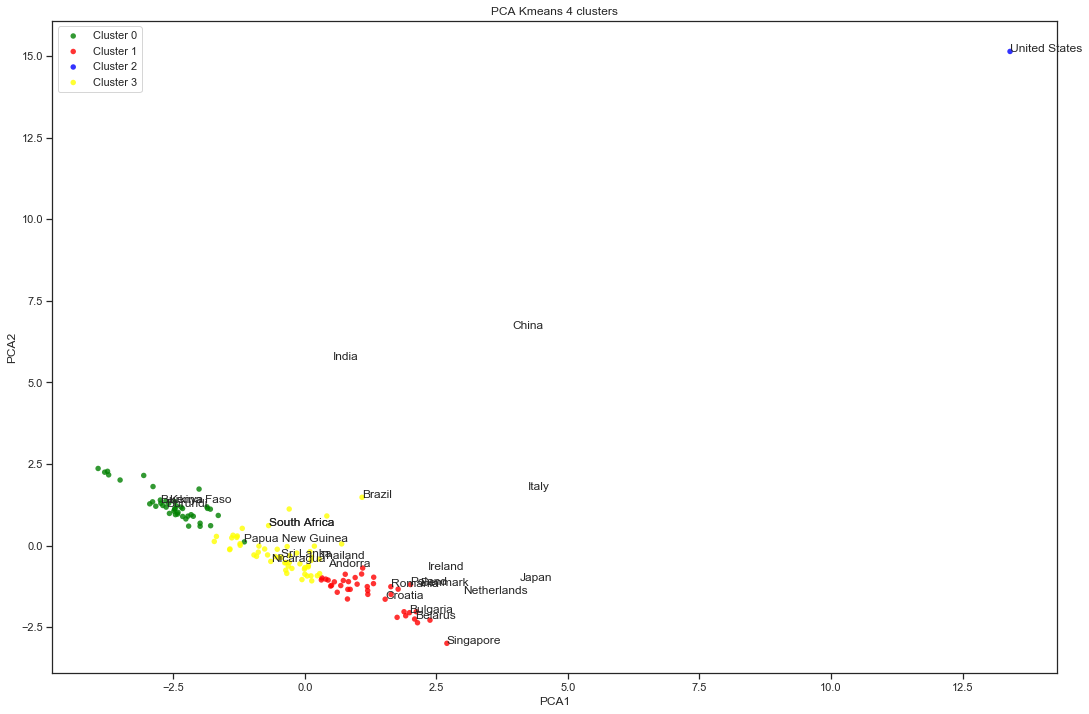

In [420]:
# zoom on n cluster solution
clusters=4

fig,ax = plt.subplots(figsize=(18,12))

model = KMeans(n_clusters=clusters)
PCA_components2 = PCA_components.copy()
kmeans = model.fit(PCA_components2.iloc[:,:3])

PCA_components2.insert(0, 'cluster', kmeans.labels_)
# display(PCA_components2[PCA_components2.index.isin(['China','Japan','United States','Italy','Spain','India','Poland'])])
# display(PCA_components2[['cluster',0]].groupby(by=['cluster']).count())

atas = []
for i in range(clusters):
    tup = []
    for j in range(clusters):
        tup.append(PCA_components2[PCA_components2['cluster']==i][j])
    datas.append(tup)

groups = ['Cluster '+str(i) for i in range(clusters)]
colors = ('green','red','blue','yellow','purple','brown')

for data,color,group in zip(datas,colors,groups):
    x,y = data[0],data[1]
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=30, label=group)
    ax.set_title(f'PCA Kmeans {clusters} clusters')
    ax.set(xlabel='PCA1')
    ax.set(ylabel='PCA2')

for index,row in PCA_components2[PCA_components2.index.isin(['China','Japan','United States',
                                                             'Singapore','South Africa','Belarus','Brazil',
                                                             'Italy','India','Poland'])].iterrows():
    ax.annotate(index, (row[0],row[1]))
for index,row in PCA_components2.sample(15).iterrows():
    ax.annotate(index, (row[0],row[1]))

plt.legend(loc=2)
plt.show()


## T-Distributed Stochastic Neighbor Embedding (T-SNE)

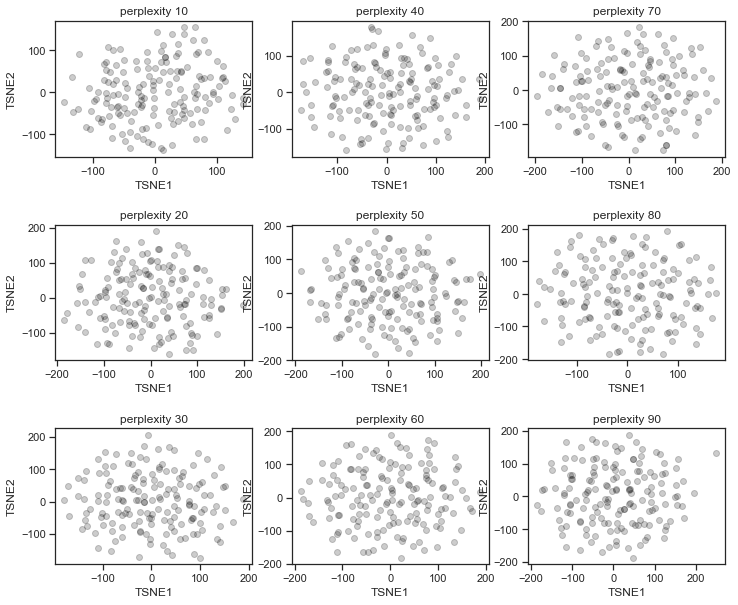

In [421]:
plotX = df_train.copy()
ps = [10,20,30,40,50,60,70,80,90]

fig,ax = plt.subplots(3, 3, figsize=(12,10))
plt.subplots_adjust(hspace=.5)
import math 

for i, perplexity in enumerate(ps):
    tsne = TSNE(n_components=3, perplexity=perplexity)
    tsneComponents = tsne.fit_transform(plotX.drop(["cluster"], axis=1))
    TSNE_components = pd.DataFrame(tsneComponents, index=plotX.index)

    ax[i%3][math.floor(i/3)].set_title(f'perplexity {perplexity}')
    ax[i%3][math.floor(i/3)].scatter(TSNE_components[0], TSNE_components[1], alpha=.2, color='black')
    ax[i%3][math.floor(i/3)].set(xlabel = 'TSNE1')
    ax[i%3][math.floor(i/3)].set(ylabel = 'TSNE2')



In [422]:
# pick perp 30 randomly, raise to 3d
tsne_comps = 3
tsne_perp = 30
tsne = TSNE(n_components=tsne_comps, perplexity=tsne_perp)
tsneComponents = tsne.fit_transform(plotX.drop(["cluster"], axis=1))
TSNE_components = pd.DataFrame(tsneComponents, index=plotX.index)

TSNE_components.head()

,0,1,2
Country/Region,,,
United States,-83.366180,154.606293,47.156395
Spain,-49.972870,-187.903900,2.198611
Italy,-127.642296,122.733627,32.978764
France,-131.714539,36.247414,49.492004
Germany,119.015663,-24.129360,144.483704


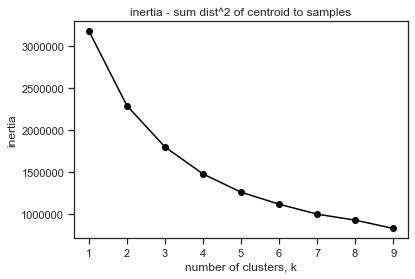

In [423]:
# KMeans on TSNE columns
ks = range(1, 10)
inertias = []
for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(TSNE_components.iloc[:,:3])
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.title('inertia - sum dist^2 of centroid to samples')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()


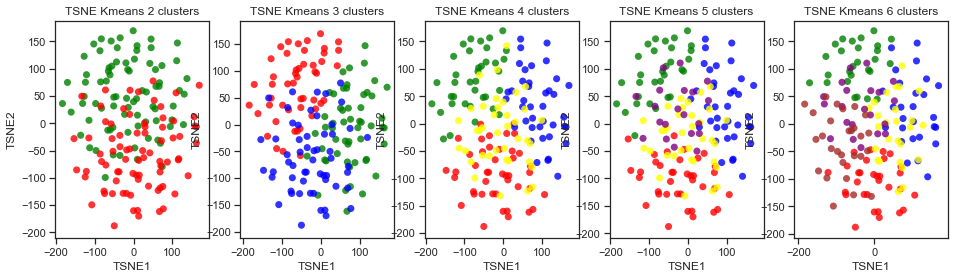

In [424]:
cluster_cases = [2,3,4,5,6]

fig,ax = plt.subplots(1,len(cluster_cases), figsize=(16,4))

for c,clusters in enumerate(cluster_cases):
    model = KMeans(n_clusters=clusters, random_state=57)
    TSNE_components2 = TSNE_components.copy()
    kmeans = model.fit(TSNE_components2.iloc[:,:3])
    TSNE_components2.insert(0, 'cluster', kmeans.labels_)

    datas = []
    for i in range(clusters):
        tup = []
        for j in range(tsne_comps):
            tup.append(TSNE_components2[TSNE_components2['cluster']==i][j])
        datas.append(tup)

    groups = ['TSNE'+str(i) for i in range(clusters)]
    colors = ('green','red','blue','yellow','purple','brown')

    for data,color,group in zip(datas,colors,groups):
        x,y = data[0],data[1]
        ax[c].scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=50, label=group)
        ax[c].set_title(f'TSNE Kmeans {clusters} clusters')
        ax[c].set(xlabel='TSNE1')
        ax[c].set(ylabel='TSNE2')
plt.show()

# hmm which one to pick?

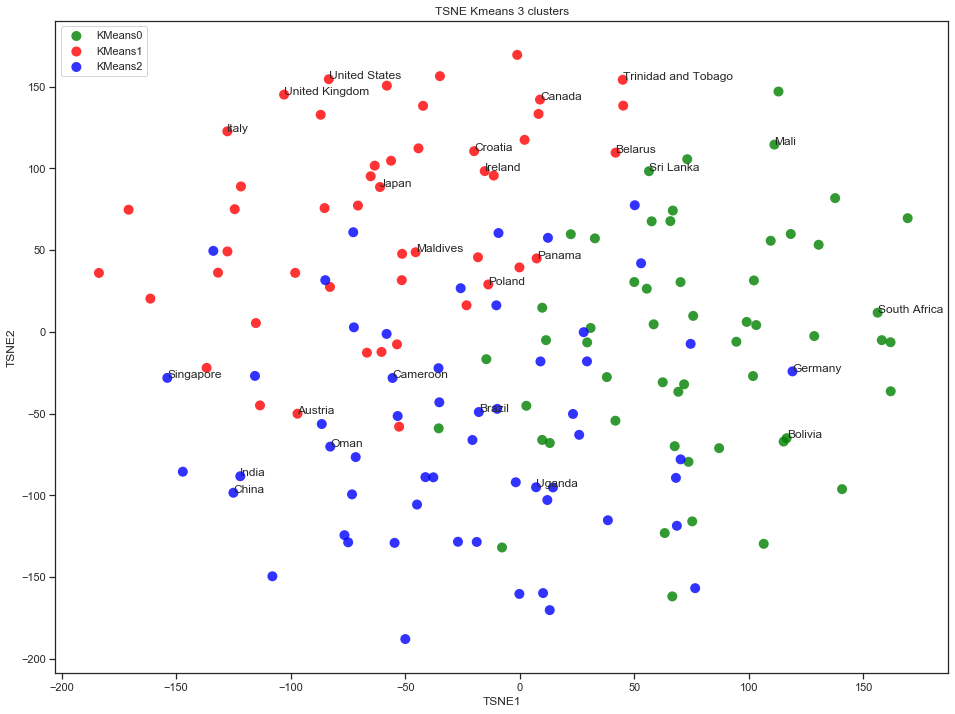

In [425]:
# kmeans 3 cluster looks good zoom on n cluster solution
clusters = 3
model = KMeans(n_clusters=clusters, random_state=57)

fig,ax = plt.subplots(figsize=(16,12))

TSNE_components2 = TSNE_components.copy()
kmeans = model.fit(TSNE_components2.iloc[:,:3])
TSNE_components2.insert(0, 'cluster', kmeans.labels_)

datas = []
for i in range(clusters):
    tup = []
    for j in range(tsne_comps):
        tup.append(TSNE_components2[TSNE_components2['cluster']==i][j])
    datas.append(tup)

groups = ['KMeans'+str(i) for i in range(clusters)]
colors = ('green','red','blue','yellow','purple','brown')

for data,color,group in zip(datas,colors,groups):
    x,y = data[0],data[1]
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=100, label=group)
    ax.set_title(f'TSNE Kmeans {clusters} clusters')
    ax.set(xlabel='TSNE1')
    ax.set(ylabel='TSNE2')
    
for index,row in TSNE_components2[TSNE_components2.index.isin(['China','Japan','United States',
                                                             'Singapore','South Africa','Belarus','Brazil',
                                                             'Italy','India','Poland'])].iterrows():
    ax.annotate(index, (row[0],row[1]))
for index,row in TSNE_components2.sample(15).iterrows():
    ax.annotate(index, (row[0],row[1]))

plt.legend(loc=2)
plt.show()


In [426]:
def make_scat(cid, rgb_color, cluster):
    return go.Scatter(
                x = cluster["TC1_2d"],
                y = cluster["TC2_2d"],
                mode = "markers",
                name = "Cluster: "+str(cid),
                marker =rgb_color,
                text = cluster.index)
    

data = [
    make_scat(0, dict(color = 'rgba(255, 128, 255, 0.8)'), cluster0),
    make_scat(1, dict(color ='rgba(255, 128, 2, 0.8)'), cluster1),
    make_scat(2, dict(color ='rgba(0, 255, 200, 0.8)'), cluster2),
]

#data = [trace1, trace2, trace3]

title = "Visualizing Clusters in Two Dimensions Using T-SNE (perplexity=" + str(perplexity) + ")"

layout = dict(title = title,
              xaxis= dict(title= 'TC1',ticklen= 5,zeroline= False),
              yaxis= dict(title= 'TC2',ticklen= 5,zeroline= False)
             )

fig = dict(data = data, layout = layout)

iplot(fig)

KeyError: 'TC1_2d'

## Tuning the Perplexity level in 2D?



In [ ]:
plotX = df_train.copy()

def build_sets(perplexity, plotX):
    tsne_2d = TSNE(n_components=2, perplexity=perplexity)

    TCs_2d = pd.DataFrame(tsne_2d.fit_transform(plotX.drop(["cluster"], axis=1)), index=plotX.index)

    TCs_2d.columns = ["TC1_2d","TC2_2d"]

    plotX = pd.concat([plotX,TCs_2d], axis=1, join='inner')

    cluster0 = plotX[plotX["cluster"] == 0]
    cluster1 = plotX[plotX["cluster"] == 1]
    cluster2 = plotX[plotX["cluster"] == 2]
    
    display(type(cluster0))
    return cluster0,cluster1,cluster2, plotX

# init_notebook_mode(connected=True)
# fig,ax = plt.subplots(1,4,figsize=(8, 12)) 

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks")

c0,c1,c2, plotX2 = build_sets(50,plotX)    

display(plotX2.head(3))

g = sns.FacetGrid(plotX2, col="cluster", hue="Cases")
g.map(plt.scatter, "TC1_2d", "TC2_2d", alpha=.7)

# # for i in [10,20,30, 40,50,60, 70,80,90]:
# for i in [10, 40]:
#     c0,c1,c2,X2 = build_sets(i,plotX)    

#     display(c0.head(3))
#     display(c1.head(3))
# #     ax[0].scatter(c0['TC1_2d'], c0['TC2_2d'])



## Need to figure out do I keep causes & deaths as indicators ?  Weigh them?  Add a cases/trending 3,7,14 day rolling avg?

# Pop Density vs Case counts

In [ ]:
max_ctys = 30
fig,ax1 = plt.subplots(figsize=(10, 8)) 

df_gmerged_h = df_gmerged2[df_gmerged2['Cases'] > 1000].sort_values(by=['popdensity'],ascending=False).head(max_ctys)

ax1.set_xlabel('Cases')  
ax1.set_xscale('linear')
ax1.barh(df_gmerged_h['Country/Region'], df_gmerged_h['Cases'], color='xkcd:green')
for n,i in enumerate(ax1.patches):
    ax1.text(i.get_width()+.02, i.get_y()+.5,'density: '+str(df_gmerged_h['popdensity'].iloc[n:n+1].round(2).item()) + ', pop: '+str(df_gmerged_h['Population'].iloc[n:n+1].div(1000000).round(0).item()) +'M, '+str(df_gmerged_h['% of pop'].iloc[n:n+1].round(2).item())  +'%', color='xkcd:blue')

# ax2 = ax1.twiny()
# ax2.set_xscale('linear')
# ax2.set(xlim=[0, 10])   # get max min +/- buffer
# ax2.set_xlabel('Population density', color='xkcd:red')  
# ax2.spines['top'].set_color('red')
# ax2.tick_params(axis='x', colors='red')
# ax2.barh(df_gmerged_h['Country/Region'], df_gmerged_h['popdensity'], color='xkcd:red')
# for n,i in enumerate(ax2.patches):
#     ax2.text(i.get_width()+.02, i.get_y()+.5,str(df_gmerged_h['popdensity'].iloc[n:n+1].item()), color='xkcd:red')

plt.title('Top Population Density Countries > 1000 cases')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# read from JSON directly WIP -- would be more optimal than above but scrap for now
# EN.ATM.PM25.MC.M3 - polution
# able to aggrecate and get last value, not sure what source= is    ?source=2&format=json&mrnev=1&per_page=500
#   http://api.worldbank.org/v2/country/all/indicator/EN.ATM.PM25.MC.M3;SH.MED.BEDS.ZS;IS.AIR.DPRT;IS.RRS.TOTL.KM;SP.URB.TOTL.IN.ZS;SP.POP.TOTL;SL.UEM.TOTL.ZS?source=2&format=json&mrnev=1&per_page=5000
#jurl = 'http://api.worldbank.org/v2/country/all/indicator/EN.ATM.PM25.MC.M3;SH.MED.BEDS.ZS;IS.AIR.DPRT;IS.RRS.TOTL.KM;SP.URB.TOTL.IN.ZS;SP.POP.TOTL;SL.UEM.TOTL.ZS?source=2&format=json&mrnev=1&per_page=5000'
    
#r = requests.get(jurl)
#display(r.text)
#    
#pd.read_json(r.text)

